# 拡散モデルの応用

拡散モデルを応用した例として代表的なものにStableDiffusionなどのアプリケーションが挙げられます。  
  
これらは主にテキスト入力を基にした画像生成、画像に基づく画像生成などに用いられる。
  
この生成を実現させているのが「**条件付き拡散モデル**」である  

## 条件付き拡散モデル

これまでの章ではデータxの確率p(x)をモデル化してきましたが何かを生成するとなったとき条件が必要になります。  
  
その条件をyとするとモデル化したいのはp(x|y)ということになります。  
  
条件はさまざまありますがMNISTデータセットの画像を新たに作りたいならラベルが条件yに当たります。  
  
先程例に出したStableDiffusionでは入力テキストや画像が条件ということになります  
  
![alt text](pict10-1.png)

### 拡散モデルの復習

8章で学んだ拡散モデルのNNは以下のようでした。  
  
![alt text](pict10-2.png)  
  
それぞれ元画像を予測するモデルと追加されたノイズを予測するモデルでした。  
  
μ(x,t)をNNでモデル化する場合で考えると

$$
p_θ(x_{t-1}|x_t)=\mathcal{N}(x_{t-1};μ_θ(x_t,t),σ_q^2(t)\mathbb{I})
$$

$$
p_\theta(x_0)=\int p_\theta(x_0,x_1,\cdots,x_T)dx_1\cdots dx_t
$$

$$
= \int p_\theta(x_0|x_1)\cdots p_\theta(x_{T-1}|x_T)p(x_T) dx_1\cdots dx_T
$$

ではこの式にyの条件を追加します。

$$
p_\theta(x_0|y)= \int p_\theta(x_0|x_1,y)\cdots p_\theta(x_{T-1}|x_T,y)p(x_T) dx_1\cdots dx_T
$$

$$
p_\theta(x_{t-1}|x_t,y) = \mathcal{N}(x_{t-1};\mu _\theta(x_t,t,y),\sigma _q^2(t)\mathbb{I})
$$

このようにyを条件に追加してモデル化できる  
  
同様にノイズを予測するモデルでもεの入力にyを追加することで対応できます  
  
![alt text](pict10-3.png)

## 条件付き拡散モデルの実装


前章で位置情報tは正弦波位置エンコーディングによってベクトルへと変換しました。  
  
今回yはラベル情報なのでyも同様にベクトル変換を施す必要があります。  
  
ではyのベクトル変換を追加したUNetCondクラスを実装していきます

In [ ]:
import math
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn.functional as F
from torch import nn
from tqdm import tqdm


img_size = 28
batch_size = 128
num_timesteps = 1000
epochs = 10
lr = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'


def show_images(images, labels=None, rows=2, cols=10):
    fig = plt.figure(figsize=(cols, rows))
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax = fig.add_subplot(rows, cols, i + 1)
            plt.imshow(images[i], cmap='gray')
            if labels is not None:
                ax.set_xlabel(labels[i].item())
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])
            i += 1
    plt.tight_layout()
    plt.show()

def _pos_encoding(time_idx, output_dim, device='cpu'):
    t, D = time_idx, output_dim
    v = torch.zeros(D, device=device)

    i = torch.arange(0, D, device=device)
    div_term = torch.exp(i / D * math.log(10000))

    v[0::2] = torch.sin(t / div_term[0::2])
    v[1::2] = torch.cos(t / div_term[1::2])
    return v

def pos_encoding(timesteps, output_dim, device='cpu'):
    batch_size = len(timesteps)
    device = timesteps.device
    v = torch.zeros(batch_size, output_dim, device=device)
    for i in range(batch_size):
        v[i] = _pos_encoding(timesteps[i], output_dim, device)
    return v

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_embed_dim):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )
        self.mlp = nn.Sequential(
            nn.Linear(time_embed_dim, in_ch),
            nn.ReLU(),
            nn.Linear(in_ch, in_ch)
        )

    def forward(self, x, v):
        N, C, _, _ = x.shape
        v = self.mlp(v)
        v = v.view(N, C, 1, 1)
        y = self.convs(x + v)
        return y

class UNetCond(nn.Module):
    def __init__(self, in_ch=1, time_embed_dim=100, num_labels=None):
        super().__init__()
        self.time_embed_dim = time_embed_dim

        self.down1 = ConvBlock(in_ch, 64, time_embed_dim)
        self.down2 = ConvBlock(64, 128, time_embed_dim)
        self.bot1 = ConvBlock(128, 256, time_embed_dim)
        self.up2 = ConvBlock(128 + 256, 128, time_embed_dim)
        self.up1 = ConvBlock(128 + 64, 64, time_embed_dim)
        self.out = nn.Conv2d(64, in_ch, 1)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')

        #①ラベルの埋め込み層
        if num_labels is not None:
            self.label_emb = nn.Embedding(num_labels, time_embed_dim)

    def forward(self, x, timesteps, labels=None):
        t = pos_encoding(timesteps, self.time_embed_dim)

        #②ラベルの処理
        if labels is not None:
            t += self.label_emb(labels)

        x1 = self.down1(x, t)
        x = self.maxpool(x1)
        x2 = self.down2(x, t)
        x = self.maxpool(x2)

        x = self.bot1(x, t)

        x = self.upsample(x)
        x = torch.cat([x, x2], dim=1)
        x = self.up2(x, t)
        x = self.upsample(x)
        x = torch.cat([x, x1], dim=1)
        x = self.up1(x, t)
        x = self.out(x)
        return x

/home/yoshida/.pyenv/versions/3.11.8/lib/python3.11/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [8]:
class Diffuser:
    def __init__(self, num_timesteps=1000, beta_start=0.0001, beta_end=0.02, device='cpu'):
        self.num_timesteps = num_timesteps
        self.device = device
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, device=device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)

    def add_noise(self, x_0, t):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()

        t_idx = t - 1  # alpha_bars[0] is for t=1
        alpha_bar = self.alpha_bars[t_idx]  # (N,)
        alpha_bar = alpha_bar.view(alpha_bar.size(0), 1, 1, 1)  # (N, 1, 1, 1)

        noise = torch.randn_like(x_0, device=self.device)
        x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * noise
        return x_t, noise

    def denoise(self, model, x, t, labels):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()

        t_idx = t - 1  # alphas[0] is for t=1
        alpha = self.alphas[t_idx]
        alpha_bar = self.alpha_bars[t_idx]
        alpha_bar_prev = self.alpha_bars[t_idx-1]

        N = alpha.size(0)
        alpha = alpha.view(N, 1, 1, 1)
        alpha_bar = alpha_bar.view(N, 1, 1, 1)
        alpha_bar_prev = alpha_bar_prev.view(N, 1, 1, 1)

        model.eval()
        with torch.no_grad():
            eps = model(x, t, labels)  # add lable embedding
        model.train()

        noise = torch.randn_like(x, device=self.device)
        noise[t == 1] = 0  # no noise at t=1

        mu = (x - ((1-alpha) / torch.sqrt(1-alpha_bar)) * eps) / torch.sqrt(alpha)
        std = torch.sqrt((1-alpha) * (1-alpha_bar_prev) / (1-alpha_bar))
        return mu + noise * std

    def reverse_to_img(self, x):
        x = x * 255
        x = x.clamp(0, 255)
        x = x.to(torch.uint8)
        x = x.cpu()
        to_pil = transforms.ToPILImage()
        return to_pil(x)

    def sample(self, model, x_shape=(20, 1, 28, 28), labels=None):
        batch_size = x_shape[0]
        x = torch.randn(x_shape, device=self.device)
        if labels is None:
            labels = torch.randint(0, 10, (len(x),), device=self.device)

        for i in tqdm(range(self.num_timesteps, 0, -1)):
            t = torch.tensor([i] * batch_size, device=self.device, dtype=torch.long)
            x = self.denoise(model, x, t, labels)

        images = [self.reverse_to_img(x[i]) for i in range(batch_size)]
        return images, labels


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:03<00:00, 2.68MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 160kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.58MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 10.9MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 469/469 [07:36<00:00,  1.03it/s]


Epoch 0 | Loss: 0.049146399005199036


100%|██████████| 469/469 [07:41<00:00,  1.02it/s]


Epoch 1 | Loss: 0.02586794200180563


100%|██████████| 469/469 [07:57<00:00,  1.02s/it]


Epoch 2 | Loss: 0.02300402133671968


100%|██████████| 469/469 [08:13<00:00,  1.05s/it]


Epoch 3 | Loss: 0.021240384522468042


100%|██████████| 469/469 [07:50<00:00,  1.00s/it]


Epoch 4 | Loss: 0.020092260430076482


100%|██████████| 469/469 [07:50<00:00,  1.00s/it]


Epoch 5 | Loss: 0.01941182227459734


100%|██████████| 469/469 [07:46<00:00,  1.01it/s]


Epoch 6 | Loss: 0.018845362906485225


100%|██████████| 469/469 [07:44<00:00,  1.01it/s]


Epoch 7 | Loss: 0.018302378898013883


100%|██████████| 469/469 [08:17<00:00,  1.06s/it]


Epoch 8 | Loss: 0.018112658981734246


100%|██████████| 469/469 [07:59<00:00,  1.02s/it]

Epoch 9 | Loss: 0.017569303619804414


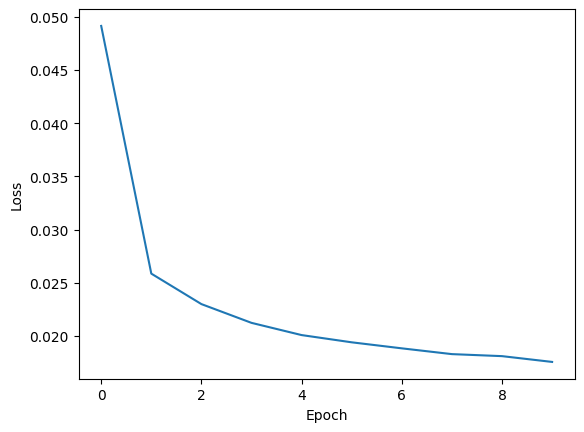

100%|██████████| 1000/1000 [00:53<00:00, 18.70it/s]


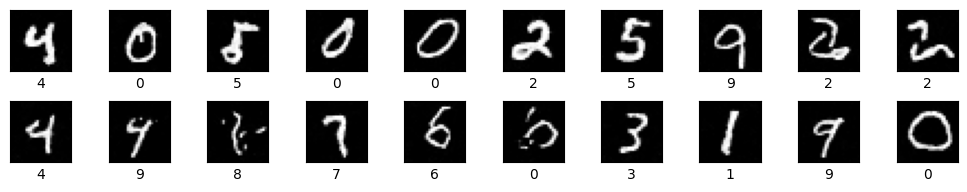

In [9]:

preprocess = transforms.ToTensor()
dataset = torchvision.datasets.MNIST(root='./data', download=True, transform=preprocess)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

diffuser = Diffuser(num_timesteps, device=device)
model = UNetCond(num_labels=10)
model.to(device)
optimizer = Adam(model.parameters(), lr=lr)

losses = []
for epoch in range(epochs):
    loss_sum = 0.0
    cnt = 0

    # generate samples every epoch ===================
    #images, labels = diffuser.sample(model)
    #show_images(images, labels)
    # ================================================

    for images, labels in tqdm(dataloader):
        optimizer.zero_grad()
        x = images.to(device)
        labels = labels.to(device)
        t = torch.randint(1, num_timesteps+1, (len(x),), device=device)

        x_noisy, noise = diffuser.add_noise(x, t)
        noise_pred = model(x_noisy, t, labels)
        loss = F.mse_loss(noise, noise_pred)

        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        cnt += 1

    loss_avg = loss_sum / cnt
    losses.append(loss_avg)
    print(f'Epoch {epoch} | Loss: {loss_avg}')

# plot losses
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# generate samples
images, labels = diffuser.sample(model)
show_images(images, labels)